# Plotting

In [ ]:
import pyvista as pv
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("~/science.mplstyle")

from pyvista import examples

pv.global_theme.font.color = 'black'
pv.global_theme.font.family = 'times'

values = np.linspace(0, 10, 1000).reshape((20, 5, 10))
values.shape

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape + 1 because we want to inject our values on
#   the CELL data
grid.dimensions = np.array(values.shape) + 1

# Edit the spatial reference
grid.origin = (100, 33, 55.6)  # The bottom left corner of the data set
grid.spacing = (1, 5, 2)  # These are the cell sizes along each axis

# Add the data values to the cell data
grid.cell_data["values"] = values.flatten(order="F")  # Flatten the array!

# Now plot the grid!
grid.plot(show_edges=False, background="white", cmap="jet")

In [ ]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt

from pyvista import examples

mesh = examples.load_channels()
cmap = plt.cm.get_cmap("viridis", 4)

slices = mesh.slice_orthogonal(x=20, y=20, z=30)
slices.plot(cmap=cmap, jupyter_backend="none", background='white', show_axes=True, screenshot='airplane.png')

# Data loading

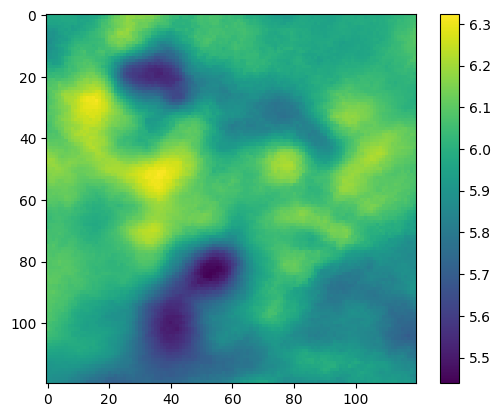

In [1]:
import pandas as pd
import numpy as np
import pymap3d as pm
import matplotlib.pyplot as plt

velocity = pd.read_csv('/home/taufikmh/KAUST/fall_2022/external_repos/copy-HCPINNsEikonal-dev/data/white2021/velocity.csv')
events = pd.read_csv('/home/taufikmh/KAUST/fall_2022/external_repos/copy-HCPINNsEikonal-dev/data/white2021/events.csv')
arrivals = pd.read_csv('/home/taufikmh/KAUST/fall_2022/external_repos/copy-HCPINNsEikonal-dev/data/white2021/arrivals.csv')

# Select data only from the 6th index (z=0km)
LAT = velocity.latitude.values.reshape(251, 301, -1)[60:180,80:200,6:44]
LON = velocity.longitude.values.reshape(251, 301, -1)[60:180,80:200,6:44]
DEP = velocity.depth.values.reshape(251, 301, -1)[60:180,80:200,6:44]
VEL = velocity.Vp.values.reshape(251, 301, -1)[60:180,80:200,6:44]

# # Select data only down to the 38th index (16 km) according to the paper
# LAT = velocity.latitude.values.reshape(251, 301, -1)[60:180,80:200,:38]
# LON = velocity.longitude.values.reshape(251, 301, -1)[60:180,80:200,:38]
# DEP = velocity.depth.values.reshape(251, 301, -1)[60:180,80:200,:38]
# VEL = velocity.Vp.values.reshape(251, 301, -1)[60:180,80:200,:38]

# 35.1, 36.3
# 117, 118.2

# focus_idx = (LAT>=35.1) & (LAT<=36.3) & (LON>=117) & (LON<=118.2)

# LAT = LAT[focus_idx]
# LON = LON[focus_idx]
# DEP = DEP[focus_idx]
# VEL = VEL[focus_idx]

plt.imshow(VEL[:,:,20])
plt.colorbar()

# Plotting Coordinates

In [20]:
vel = np.moveaxis(np.copy(VEL), -1, 0)

xplot = np.linspace(0, 7.15253852470341, vel3d.shape[1])*18.1
yplot = np.linspace(0, 7.15253852470341, vel3d.shape[1])*18.1
zplot = np.linspace(0, 1, vel3d.shape[0])*18.1

LON[0,:,0][xplot.round(2)==43.52], LAT[0,:,0][yplot.round(1)==1.8]

(array([-117.8]), array([], dtype=float64))

In [29]:
LON[0,40,0], LAT[50,0,0]

(-117.8, 35.6)

In [34]:
xplot.size*yplot.size*zplot.size*4**2//2000

11520

## Extended depth

In [ ]:
latitude = np.linspace(LAT.min(), LAT.max(), LAT.shape[0])
longitude = np.linspace(LON.min(), LON.max(), LON.shape[1])
depth = np.linspace(DEP.min(), DEP.max(), 100)

ELAT, ELON, EDEP = np.meshgrid(latitude, longitude, depth)

ELAT = np.moveaxis(np.copy(ELAT), -1, 0)
ELON = np.moveaxis(np.copy(ELON), -1, 0)
EDEP = np.moveaxis(np.copy(EDEP), -1, 0)

In [ ]:
for i in range(len(depth)):
    try:
        j = np.where(np.abs(DEP[0,0,:]-depth[i].round(2))<1e-2)[0][0]
        print(DEP[0,0,j], depth[i])
    except:
        pass
print(i)

## Projection

In [ ]:
# LAT, ALT, LON = np.meshgrid(latitude, -1e3*depth, longitude)
# x, y, z = pm.geodetic2ecef(LAT, LON, ALT)
# _, DEP, _ = np.meshgrid(latitude, depth, longitude)

## Fetch stations location

In [ ]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
client = Client()

dictionary_list = []    

NET = np.unique(arrivals.network.values) #"GS"

for net in NET:
    STA = np.unique(arrivals[arrivals.network==net].station.values)
    
    for sta in STA:
        try:
            
            CHA = client.get_stations(network=net, station=sta, level="channel")[0][0][0]
        
            dictionary_data = {
                'network':net,
                'station':sta,
                'latitude':CHA.latitude,
                'longitude':CHA.longitude,
                'elevation':CHA.elevation,
                'local_depth':CHA.depth
            }
            dictionary_list.append(dictionary_data)

        except:
            pass
        
stations = pd.DataFrame.from_dict(dictionary_list)

stations.to_csv('../data/white2021/stations.csv',index_label=False)

In [ ]:
stations = pd.read_csv('../data/white2021/stations.csv')

## Filter data based on arrivals residuals

In [ ]:
data = pd.merge(events, arrivals,  
                how='left', 
                left_on=['event_id'], 
                right_on = ['event_id'], 
                suffixes=('_event','_arrival')
).drop_duplicates()

filtered_events = data[(data.phase=='P') & (np.abs(data.residual_arrival)<=5e-4)]

filtered_stations = pd.merge(stations, filtered_events,  
                             how='left', left_on=['station'], right_on = ['station'], 
                             suffixes=('_station','_event')
).drop_duplicates()
filtered_stations['event_id'] = filtered_stations['event_id'].values.astype(int)

# Select only events and stations inside focus area
# [-118.2, -117.01, 35.1, 36.29]
filtered_events = filtered_events[
    (filtered_events.latitude<36.29) & (filtered_events.latitude>35.1) &
    (filtered_events.longitude<-117.01) & (filtered_events.longitude>-118.2) 
]

filtered_stations = filtered_stations[
    (filtered_stations.latitude_station<36.29) & (filtered_stations.latitude_station>35.1) &
    (filtered_stations.longitude_station<-117.01) & (filtered_stations.longitude_station>-118.2) 
]

filtered_events = filtered_events.round({'latitude':2, 'longitude':2, 'depth':2}).drop_duplicates()
filtered_stations = filtered_stations.round({'latitude_station':2, 'longitude_station':2, 'elevation':2}).drop_duplicates()

In [ ]:
print(np.unique(filtered_events.latitude.round(2)).shape, np.unique(filtered_events.longitude.round(2)).shape)
plt.scatter(filtered_stations.longitude_station.values, filtered_stations.latitude_station.values)
plt.scatter(filtered_events.longitude.values.round(2), filtered_events.latitude.values.round(2))
plt.scatter([np.min(LON[:,:,0]), np.max(LON[:,:,0]), np.min(LON[:,:,0]), np.max(LON[:,:,0])], 
            [np.max(LAT[:,:,0]), np.max(LAT[:,:,0]), np.min(LAT[:,:,0]), np.min(LAT[:,:,0])])
# plt.xlim(-117, -118.2)
# plt.ylim(35.1, 36.3)

# Load elevation data

In [ ]:
import pygmt
# Load a grid of @earth_relief_30m data, with an x-range of -118 to
# -107, and a y-range of -49 to -42
grid = pygmt.datasets.load_earth_relief(
    resolution="10m", region=[-118.2, -117.01, 35.1, 36.29]
)

points = pd.DataFrame(
    data=np.hstack((LON[:,:,0].reshape(-1,1),LAT[:,:,0].reshape(-1,1))),
    columns=["x", "y"],
)

# Create a pandas dataframe from an input grid and set of points
# The output dataframe adds a column named "bathymetry"
output_dataframe = pygmt.grdtrack(
    points=points, grid=grid, newcolname="elevation"
)

output_dataframe['elevation']=output_dataframe['elevation']/1000

output_dataframe.to_csv('../data/white2021/elevations.csv',index_label=False)

In [ ]:
output_dataframe = pd.read_csv('../data/white2021/elevations.csv')

# Point-source synthetic test

In [ ]:
from math import cos, asin, sqrt, pi

def distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a))

In [ ]:
# Horizontal distance
max_hoffset = distance(LAT.min(), LON.min(), LAT.min(), LON.max())
max_voffset = distance(LAT.min(), LON.min(), LAT.max(), LON.min())

max_hoffset, max_voffset

In [ ]:
np.sqrt(distance(35.460120, -117.771060, 35.613941, -117.493740)**2 + (7.301716+896.3/1000)**2)

## Extended depth

### Source indices

In [ ]:
filtered_events[
    (filtered_events.depth<EDEP.max()) & 
    (filtered_events.latitude<LAT.max()) & 
    (filtered_events.latitude>LAT.min()) &
    (filtered_events.longitude<LON.max()) & 
    (filtered_events.longitude>LON.min()) 
    # ()
].drop_duplicates()

In [ ]:
id_sou = []
idx_all = np.arange(EDEP.size).reshape(EDEP.shape)

for i in range(len(filtered_events)):

    try:
        idx = np.where(
            (np.abs(filtered_events.iloc[i].latitude-ELAT)<1e-3) 
            & (np.abs(filtered_events.iloc[i].longitude-ELON)<1e-3)
            & (np.abs(depth[5].round(3)-EDEP.round(3))<4e-2)
        )
        id_sou.append(idx_all[idx[0][0], idx[1][0], idx[2][0]])
        
#         id_x, id_y, id_z = np.unravel_index(np.where(
#             (np.abs(filtered_events.iloc[i].latitude-ELAT)<1e-3) 
#             & (np.abs(filtered_events.iloc[i].longitude-ELON)<1e-3)
#             & (np.abs(filtered_events.iloc[i].depth.round(3)-EDEP.round(3))<4e-2)
# ), EDEP.shape)[2]
#         id_sou.append(idx_all[id_x[0], id_y[0], id_z[0]])

    except:
        pass

np.save('id_sou_z5_100.npy', id_sou)
    
np.array(id_sou).shape, np.unique(np.array(id_sou)).shape

In [ ]:
len(id_sou)//10

In [ ]:
np.unique(EDEP.reshape(-1)[id_sou])

### Receiver indices

In [ ]:
id_rec = []
idx_all = np.arange(EDEP.size).reshape(EDEP.shape)

for i in range(len(filtered_stations)):

    try:
        idx = np.where(
            (np.abs(filtered_stations.iloc[i].latitude_station-ELAT)<1e-3) 
            & (np.abs(filtered_stations.iloc[i].longitude_station-ELON)<1e-3)
            & (np.abs(0-EDEP.round(3))<4e-2)
        )
        id_rec.append(idx_all[idx[0][0], idx[1][0], idx[2][0]])
        
#         id_x, id_y, id_z = np.unravel_index(np.where(
#             (np.abs(filtered_stations.iloc[i].latitude_station-ELAT)<1e-3) 
#             & (np.abs(filtered_stations.iloc[i].longitude_station-ELON)<1e-3)
#             & (np.abs(0-EDEP.round(3))<4e-2)
# ), EDEP.shape)[2]
#         id_rec.append(idx_all[id_x[0], id_y[0], id_z[0]])

    except:
        pass

np.save('id_rec_z100.npy', id_rec)
    
np.array(id_rec).shape, np.unique(np.array(id_rec)).shape

In [ ]:
id_rec

## Input depth

### Source indices

In [ ]:
id_sou = []
idx_all = np.arange(DEP.size).reshape(DEP.shape)

for i in range(len(filtered_events)):

    try:
        idx = np.where(
            (np.abs(filtered_events.iloc[i].latitude-LAT)<1e-3) 
            & (np.abs(filtered_events.iloc[i].longitude-LON)<1e-3)
            & (np.abs(dep[3]-DEP.round(3))<4e-6)
        )
        id_sou.append(idx_all[idx[0][0], idx[1][0], idx[2][0]])
        
#         id_x, id_y, id_z = np.unravL_index(np.where(
#             (np.abs(filtered_events.iloc[i].latitude-LAT)<1e-3) 
#             & (np.abs(filtered_events.iloc[i].longitude-LON)<1e-3)
#             & (np.abs(filtered_events.iloc[i].depth.round(3)-DEP.round(3))<4e-2)
# ), DEP.shape)[2]
#         id_sou.append(idx_all[id_x[0], id_y[0], id_z[0]])

    except:
        pass

np.save('id_sou_z38.npy', id_sou)
    
np.array(id_sou).shape, np.unique(np.array(id_sou)).shape

### Receiver indices

In [ ]:
id_rec = []
idx_all = np.arange(DEP.size).reshape(DEP.shape)

for i in range(len(filtered_stations)):

    try:
        idx = np.where(
            (np.abs(filtered_stations.iloc[i].latitude_station-LAT)<1e-3) 
            & (np.abs(filtered_stations.iloc[i].longitude_station-LON)<1e-3)
            & (np.abs(0-DEP.round(5))<4e-2)
        )
        id_rec.append(idx_all[idx[0][0], idx[1][0], idx[2][0]])
        
#         id_x, id_y, id_z = np.unravL_index(np.where(
#             (np.abs(filtered_stations.iloc[i].latitude_station-LAT)<1e-3) 
#             & (np.abs(filtered_stations.iloc[i].longitude_station-LON)<1e-3)
#             & (np.abs(0-DEP.round(3))<4e-2)
# ), DEP.shape)[2]
#         id_rec.append(idx_all[id_x[0], id_y[0], id_z[0]])

    except:
        pass

np.save('id_rec_z38.npy', id_rec)
    
np.array(id_rec).shape, np.unique(np.array(id_rec)).shape

In [ ]:
i = 4
id_x, id_y, id_z = np.unravel_index(np.where(
            (np.abs(filtered_events.iloc[i].latitude-ELAT)<1e-3) 
            & (np.abs(filtered_events.iloc[i].longitude-ELON)<1e-3)
            & (np.abs(filtered_events.iloc[i].depth.round(3)-EDEP.round(3))<4e-2)
), EDEP.shape)[2]
id_sou.append(idx_all[id_x[0], id_y[0], id_z[0]])

In [ ]:
np.where(
    (np.abs(filtered_events.iloc[i].latitude-ELAT)<1e-3) 
    & (np.abs(filtered_events.iloc[i].longitude-ELON)<1e-3)
    & (np.abs(filtered_events.iloc[i].depth.round(3)-EDEP.round(3))<4e-2)
)[1][0]

In [ ]:
id_rec = []

for i in range(len(filtered_stations)):

    try:
        id_sou.append(np.where(
            (np.abs(filtered_stations.iloc[i].latitude_station-LAT)<1e-3) 
            & (np.abs(filtered_stations.iloc[i].longitude_station-LON)<1e-3)
            & (np.abs(0-DEP)<1e-1)
        )[0][0])
        
    except:
        pass
    
np.array(id_rec).shape, np.unique(np.array(id_rec)).shape

# Summary

In [ ]:
# Before scaling

print('max_Z: ' + str(DEP.max()-DEP.min()))
print('max_Y: ' + str(max_voffset))
print('max_X: ' + str(max_hoffset))

# After scaling

print('max_Z: ' + str((DEP.max()-DEP.min())/19))
print('max_Y: ' + str(max_voffset/19))
print('max_X: ' + str(max_hoffset/19))

In [ ]:
VEL[:,:,0]

In [ ]:
DEP[0,0,6:44]

# Spread-out sampling

From [Stack Overflow](https://stackoverflow.com/questions/69195903/sample-n-points-from-a-set-of-3d-points-that-maximizes-the-minimum-distance)

In [ ]:

import numpy as np

np.random.seed(1234)
points = np.random.uniform(0, 10, (500, 1))


def spread_sampling(points, len_index):
    # Get distances between all points
    d = distance_matrix(points, points)

    # Zero the identical upper triangle
    dt = np.tril(d)

    # List the distances and their indexes
    dtv = [(dt[i, j], i, j) for (i, j) in np.argwhere(dt > 0)]

    # Sort the list
    dtvs = sorted(dtv, key=lambda x: x[0], reverse=True)

    kpoint_index = set()
    k = len_index
    i = 0

    for p in (j for i in dtvs for j in i[1:]):
        kpoint_index.add(p)
        if len(kpoint_index) == k:
            break
            
    return points[list(kpoint_index)]



In [ ]:
spread_sampling(points, 20)